<a href="https://colab.research.google.com/github/neha702/Face-mask-detector/blob/main/Face_mask_detection_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [46]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [47]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [48]:
import cv2
from keras.models import Sequential
from keras.layers import Conv2D, Input,ZeroPadding2D, BatchNormalization, Activation, MaxPooling2D, Flatten, Dense,Dropout
from keras.preprocessing.image import ImageDataGenerator

In [49]:
train='/content/gdrive/MyDrive/face mask detection datasets/train'
test='/content/gdrive/MyDrive/face mask detection datasets/test'

In [50]:
model = Sequential([
    Conv2D(128, (3,3), activation='relu',input_shape=(100,100,3)), #Filter size: powers of 2
    MaxPooling2D(2,2),
    
    Conv2D(128, (3,3), activation='relu'),
    MaxPooling2D(2,2),
  
    Flatten(),
     Dropout(0.5),
    Dense(50, activation='relu'),
    Dense(2, activation='softmax') #As only two possibilites on or off
])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])

In [51]:
train_data=ImageDataGenerator(rescale=1.0/255)
test_data=ImageDataGenerator(rescale=1.0/255)

In [52]:
train_generator = train_data.flow_from_directory(train, 
                                                    batch_size=50, 
                                                    target_size=(100, 100))
test_generator = test_data.flow_from_directory(test, 
                                                    batch_size=50, 
                                                    target_size=(100, 100))

Found 1315 images belonging to 2 classes.
Found 194 images belonging to 2 classes.


In [53]:
from keras.callbacks import TensorBoard, ModelCheckpoint

In [54]:
checkpoint = ModelCheckpoint('model2-{epoch:03d}.model',monitor='val_loss',verbose=0,save_best_only=True,mode='auto')

In [55]:
from keras.models import Model, load_model

In [56]:
history = model.fit_generator(train_generator,
                              epochs=10,
                              validation_data=test_generator,
                              callbacks=[checkpoint])

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/10
27/27 [==============================] - 8s 296ms/step - loss: 0.7525 - acc: 0.5406 - val_loss: 0.4666 - val_acc: 0.8711
INFO:tensorflow:Assets written to: model2-001.model/assets
Epoch 2/10
27/27 [==============================] - 8s 282ms/step - loss: 0.3803 - acc: 0.8762 - val_loss: 0.1950 - val_acc: 0.9433
INFO:tensorflow:Assets written to: model2-002.model/assets
Epoch 3/10
27/27 [==============================] - 8s 279ms/step - loss: 0.1885 - acc: 0.9359 - val_loss: 0.1331 - val_acc: 0.9536
INFO:tensorflow:Assets written to: model2-003.model/assets
Epoch 4/10
27/27 [==============================] - 8s 272ms/step - loss: 0.1205 - acc: 0.9511 - val_loss: 0.1433 - val_acc: 0.9433
Epoch 5/10
27/27 [==============================] - 8s 275ms/step - loss: 0.1202 - acc: 0.9562 - val_loss: 0.1146 - val_acc: 0.9536
INFO:tensorflow:Assets written to: model2-005.model/assets
Epoch 6/10
27/27 [==============================] - 8s 285ms/step - loss: 0.0778 - acc: 0.9769 - val_los

In [58]:
print(model.summary())

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_13 (Conv2D)           (None, 98, 98, 128)       3584      
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 49, 49, 128)       0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 47, 47, 128)       147584    
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 23, 23, 128)       0         
_________________________________________________________________
flatten_6 (Flatten)          (None, 67712)             0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 67712)             0         
_________________________________________________________________
dense_12 (Dense)             (None, 50)               

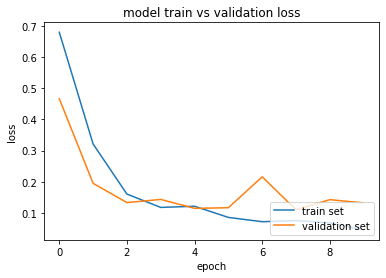

In [59]:
plt.plot(history.history['loss'],label='train')
plt.plot(history.history['val_loss'],label='validation')
plt.title('model train vs validation loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(["train set", "validation set"], loc ="lower right") 
plt.show()


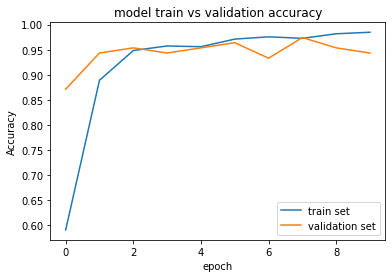

In [60]:
plt.plot(history.history['acc'],label='train')
plt.plot(history.history['val_acc'],label='validation')
plt.title('model train vs validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('epoch')
plt.legend(["train set", "validation set"], loc ="lower right") 
plt.show()

In [61]:
model=load_model("/content/model2-002.model")
haarcascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
results={0:'without mask',1:'mask'}
GR_dict={0:(0,0,255),1:(0,255,0)}

In [73]:
#Face detector function
def face_mask_detector(img):
  faces=haarcascade.detectMultiScale(img)
  for (x, y, w, h) in faces:
    cv2.rectangle(img, (x, y), (x+w, y+h), (0, 255, 0), 3)
    face_img = img[y:y+h, x:x+w]
    rerect_sized=cv2.resize(face_img,(100,100))
    normalized=rerect_sized/255.0
    reshaped=np.reshape(normalized,(1,100,100,3))
    reshaped = np.vstack([reshaped])
    result=model.predict(reshaped)
    label=np.argmax(result,axis=1)[0]
      
    cv2.rectangle(img,(x,y),(x+w,y+h),GR_dict[label],2)
    cv2.rectangle(img,(x,y-40),(x+w,y),GR_dict[label],-1)
    cv2.putText(img, results[label], (x, y-10),cv2.FONT_HERSHEY_SIMPLEX,0.8,(255,255,255),2)


    key = cv2.waitKey(10)
    
    if key == 27: 
     break

  

  cv2.destroyAllWindows()
  return img

In [74]:
from google.colab.patches import cv2_imshow

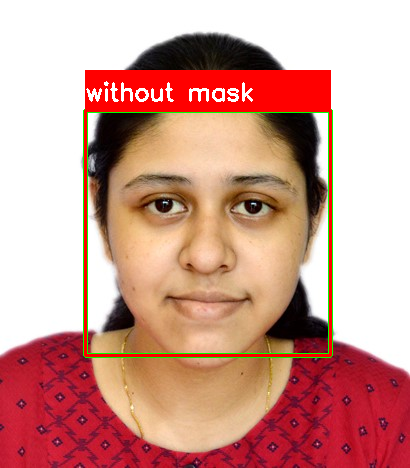

In [75]:
input_image = cv2.imread("/content/DSC_0450.jpg")
output = face_mask_detector(input_image)
cv2_imshow(output)

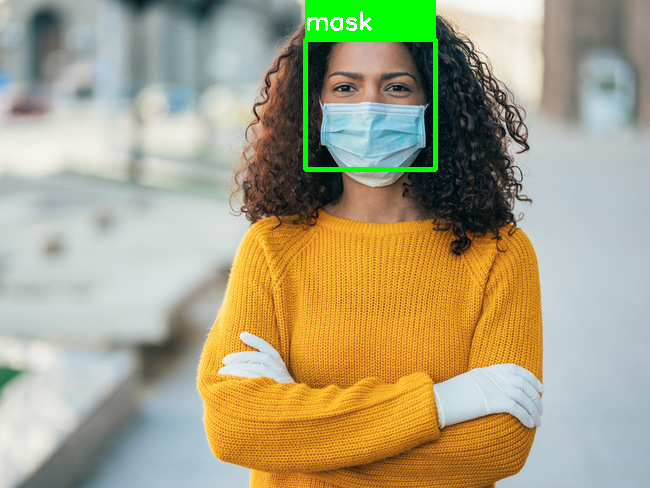

In [82]:
input_image = cv2.imread("/content/ss.jpg")
output = face_mask_detector(input_image)
cv2_imshow(output)

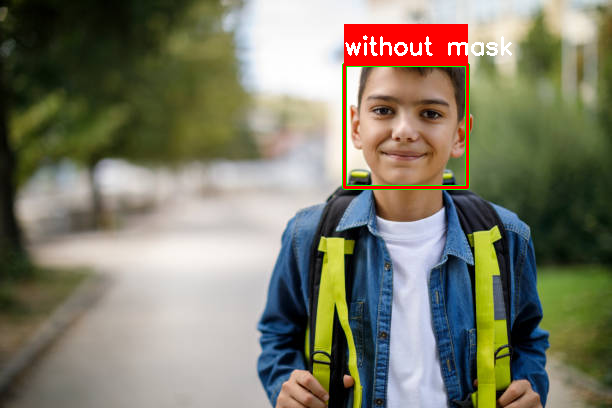

In [85]:
input_image = cv2.imread("/content/lil.jpg")
output = face_mask_detector(input_image)
cv2_imshow(output)

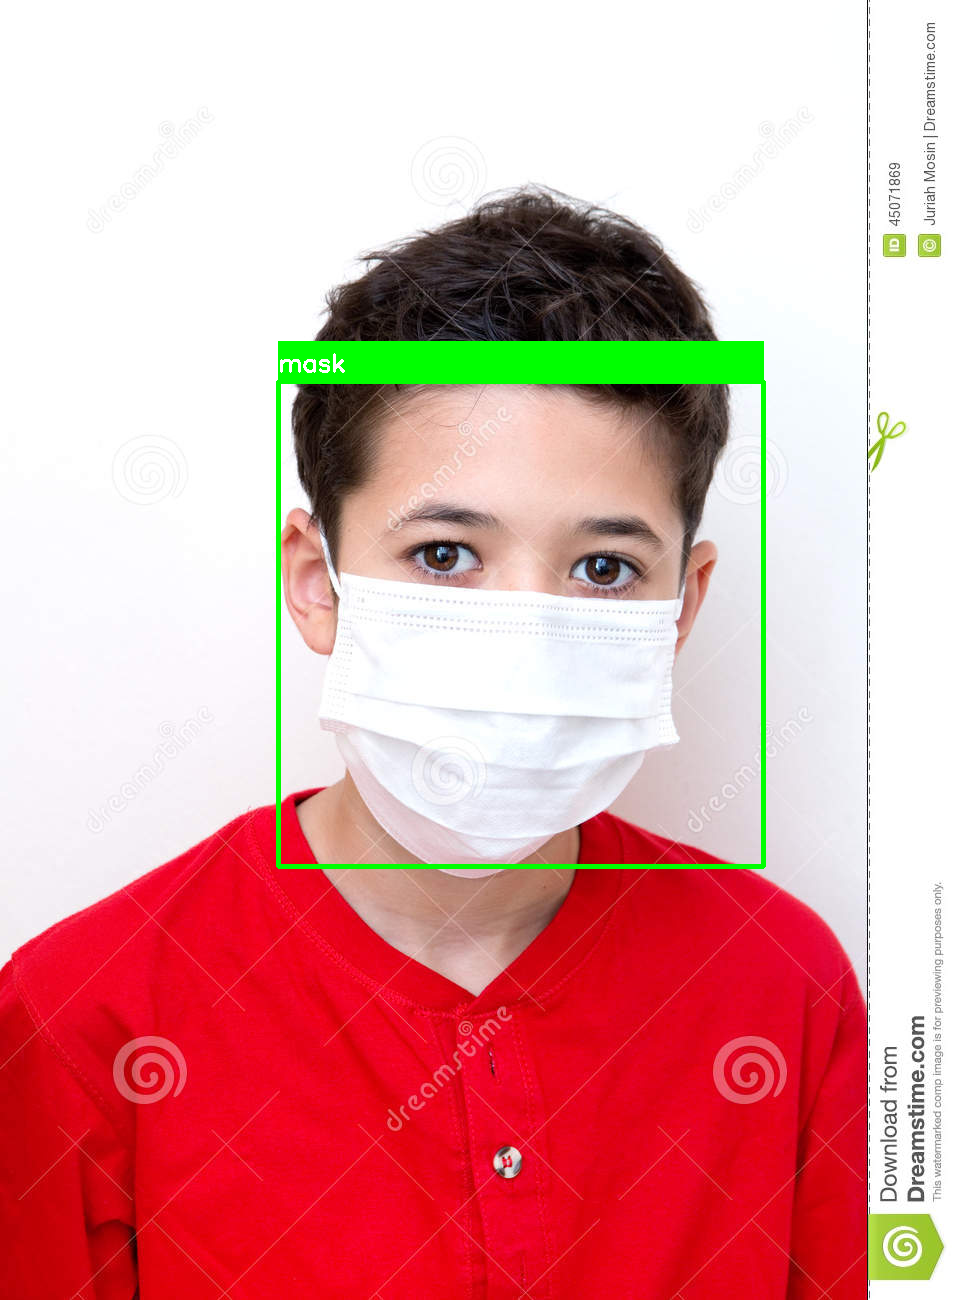

In [87]:
input_image = cv2.imread("/content/boy_mask.jpg")
output = face_mask_detector(input_image)
cv2_imshow(output)